# Import Packages

In [1]:
from packages import *
%matplotlib inline

# Read Dataset

In [2]:
df = pd.read_csv("virufy-cdf-coughvid.csv")

In [3]:
df.head()

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
0,0,coughvid,ae029647-ddc3-47f5-904e-813358c9dda3,0.8929,virufy-cdf-coughvid/ae029647-ddc3-47f5-904e-81...,NaN,NaN,NaN,2020-10-20T11:05:04.501905+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
1,1,coughvid,cac4a470-bb86-4db9-9453-d4e2706c3931,0.1431,virufy-cdf-coughvid/cac4a470-bb86-4db9-9453-d4...,NaN,NaN,NaN,2020-04-17T15:12:14.379396+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
2,2,coughvid,2a3d201f-7c70-449c-adc5-50de728fccd0,0.0803,virufy-cdf-coughvid/2a3d201f-7c70-449c-adc5-50...,38.0,male,male,2020-04-09T20:56:01.725275+00:00,NaN,NaN,False,False,untested,negative,False
3,3,coughvid,8b267d78-97f0-4530-bbfa-e938724376f4,0.1247,virufy-cdf-coughvid/8b267d78-97f0-4530-bbfa-e9...,NaN,NaN,NaN,2020-04-11T11:12:19.213465+00:00,NaN,NaN,NaN,NaN,untested,untested,NaN
4,4,coughvid,68d5215b-afdb-4b7a-81d3-fbd5677de7b4,1.0000,virufy-cdf-coughvid/68d5215b-afdb-4b7a-81d3-fb...,46.0,male,male,2020-11-26T16:21:47.764016+00:00,NaN,NaN,False,False,untested,negative,False


In [4]:
df.shape

(22040, 16)

# Preprocessing

In [5]:
df.columns

Index(['Unnamed: 0', 'source', 'patient_id', 'cough_detected', 'cough_path',
       'age', 'biological_sex', 'reported_gender', 'submission_date',
       'pcr_test_date', 'pcr_result_date', 'respiratory_condition',
       'fever_or_muscle_pain', 'pcr_test_result', 'pcr_test_result_inferred',
       'covid_symptoms'],
      dtype='object')

In [6]:
# convert all string columns to lowercase
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [7]:
# If you listen to the recordings, you might notice that some of the recordings aren't coughs.
# cough_detected column tells whether the sound file is really a cough.
# we filter our dataset, keeping only those recordings that are at least 70% likely to be coughs.
msk = (df.loc[:,'cough_detected'] > 0.7)
df = df.loc[msk,:]

In [8]:
# we have inferred some of these pcr_test_result labels based on other columns
# Positive, negative, untested
# Filter out untested results
msk = (df.loc[:,'pcr_test_result_inferred']=='untested')
df = df.loc[~msk,:]

In [9]:
# check if reported_gender and biological_sex columns are same
df['reported_gender'].equals(df['biological_sex'])

True

In [10]:
# display unique values in every column
for i in df.columns:
    print(i,df[i].nunique())
    print('*'*100)

Unnamed: 0 7766
****************************************************************************************************
source 1
****************************************************************************************************
patient_id 7766
****************************************************************************************************
cough_detected 1953
****************************************************************************************************
cough_path 7766
****************************************************************************************************
age 89
****************************************************************************************************
biological_sex 3
****************************************************************************************************
reported_gender 3
****************************************************************************************************
submission_date 7766
****************************************************

In [11]:
# check for null values
df.isnull().sum()/df.shape[0]

Unnamed: 0                  0.000000
source                      0.000000
patient_id                  0.000000
cough_detected              0.000000
cough_path                  0.000000
age                         0.055112
biological_sex              0.000000
reported_gender             0.000000
submission_date             0.000000
pcr_test_date               1.000000
pcr_result_date             1.000000
respiratory_condition       0.000000
fever_or_muscle_pain        0.000000
pcr_test_result             0.000000
pcr_test_result_inferred    0.000000
covid_symptoms              0.075715
dtype: float64

In [12]:
# select useful columns only
df = df[['age', 'biological_sex','respiratory_condition','fever_or_muscle_pain','pcr_test_result_inferred']]

In [13]:
# Imputation of missing values based on class labels
pos_samples = df.loc[df['pcr_test_result_inferred']=='positive']
pos_samples['age'] = pos_samples['age'].fillna(int(pos_samples['age'].median()))

neg_samples = df.loc[df['pcr_test_result_inferred']=='negative']
neg_samples['age'] = neg_samples['age'].fillna(int(neg_samples['age'].median()))

df = pd.concat([neg_samples,pos_samples],axis=0)
df.head()

,age,biological_sex,respiratory_condition,fever_or_muscle_pain,pcr_test_result_inferred
4,46.0,male,False,False,negative
5,47.0,male,False,False,negative
12,24.0,male,False,False,negative
14,18.0,male,False,False,negative
15,58.0,male,False,False,negative


In [14]:
df.shape

(7766, 5)

In [15]:
# drop records with null values
df = df.dropna()
df.shape

(7766, 5)

In [16]:
# drop duplicate records
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(725, 5)

In [17]:
df['biological_sex'].value_counts()

male      367
female    323
other      35
Name: biological_sex, dtype: int64

In [18]:
# remove rows with other gender
indices = [i for i in range(df.shape[0]) if df['biological_sex'][i] !='other']
df = df.loc[indices]

In [19]:
# display unique values in every column
for i in df.columns:
    print(i,df[i].nunique())
    print('*'*100)

age 89
****************************************************************************************************
biological_sex 2
****************************************************************************************************
respiratory_condition 2
****************************************************************************************************
fever_or_muscle_pain 2
****************************************************************************************************
pcr_test_result_inferred 2
****************************************************************************************************


In [20]:
for i in df.columns[:-1]:
    if(df[i].nunique()==2):
        data = pd.get_dummies(df[i], prefix=i, prefix_sep='_')
        data = data.iloc[:,:len(data.columns)-1]
        df[i] = data
        
df['pcr_test_result_inferred'] =[0 if i=='negative' else 1 for i in df['pcr_test_result_inferred']]
df.head()

,age,biological_sex,respiratory_condition,fever_or_muscle_pain,pcr_test_result_inferred
0,46.0,0,1,1,0
1,47.0,0,1,1,0
2,24.0,0,1,1,0
3,18.0,0,1,1,0
4,58.0,0,1,1,0


# Train-test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],
                                                    df['pcr_test_result_inferred'],
                                                    test_size=0.10,
                                                    stratify = df['pcr_test_result_inferred'],
                                                   random_state = 100)

In [22]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((621, 4), (621,), (69, 4), (69,))

In [23]:
print('Training Class Distribution:',Counter(y_train))
print('Testing Class Distribution:',Counter(y_test))

Training Class Distribution: Counter({0: 408, 1: 213})
Testing Class Distribution: Counter({0: 45, 1: 24})


In [24]:
# 0 -negative
# 1 - positive

# Feature Scaling

In [26]:
mean = X_train['age'].mean()
std = X_train['age'].std()
print(mean,std)

X_train['age'] = round((X_train['age']-mean)/std,2)
X_test['age'] = round((X_test['age']-mean)/std,2)

38.35619967793881 19.45762345959928


# Handle Class Imbalance

In [27]:
# SMOTE for Oversampling
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [28]:
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((816, 4), (816,), (69, 4), (69,))

In [29]:
print('Training Class Distribution:',Counter(y_train))
print('Testing Class Distribution:',Counter(y_test))

Training Class Distribution: Counter({0: 408, 1: 408})
Testing Class Distribution: Counter({0: 45, 1: 24})


# Define Functions

In [30]:
def scores(clf):
    print("Training set score: {:.3f}".format(clf.score(X_train, y_train)))
    print("Test set score: {:.3f}".format(clf.score(X_test, y_test)))

In [31]:
def test_report(clf):
    y_pred = clf.predict(X_test)
    labels = ['Non-COVID-19','COVID-19']
    
    array = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(array, index = labels, columns = labels)
    
    plt.title("Confusion Matrix")
    s = sns.heatmap(df_cm, annot=True, cmap='copper', fmt='g')
    s.set(xlabel='Predicted Label', ylabel='True Label')
    print('*'*100)
    
    print(classification_report(y_test, y_pred, target_names = labels))

In [32]:
def roc(clf):
    disp = RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.title('ROC Curve')
    plt.plot([0,1],[0,1],'k--')
    plt.show()

In [33]:
params = {}
models = {}

def call(name,model,space):
    
    clf = GridSearchCV(estimator = model, 
                      param_grid = space,
                      cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42),
                       scoring = 'recall',
                      verbose= 0,
                      n_jobs = -1)
    
    clf.fit(X_train, y_train)
    print('Best training parameters:',clf.best_params_)
     
    best_estimator = clf.best_estimator_
    
    scores(best_estimator)
    print('*'*100)
    
    test_report(best_estimator)
    print('*'*100)
    
    roc(best_estimator)
    
    params[name] = clf.best_params_
    models[name] = best_estimator

# Naiive Bayes

Best training parameters: {'var_smoothing': 1.0}
Training set score: 0.585
Test set score: 0.522
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       0.75      0.40      0.52        45
    COVID-19       0.40      0.75      0.52        24

    accuracy                           0.52        69
   macro avg       0.57      0.57      0.52        69
weighted avg       0.63      0.52      0.52        69

****************************************************************************************************


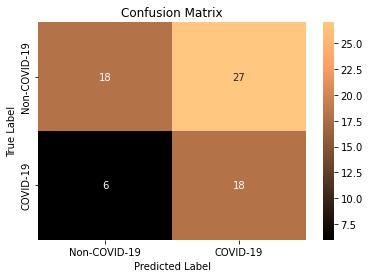

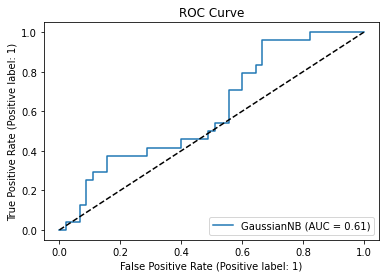

In [34]:
# Domain/Search Space
space = {'var_smoothing': np.logspace(0,-9, num=100)}

# training
model = GaussianNB()
call('NB', model, space)

# Random Forest

Best training parameters: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Training set score: 0.663
Test set score: 0.464
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       0.61      0.49      0.54        45
    COVID-19       0.30      0.42      0.35        24

    accuracy                           0.46        69
   macro avg       0.46      0.45      0.45        69
weighted avg       0.50      0.46      0.48        69

****************************************************************************************************


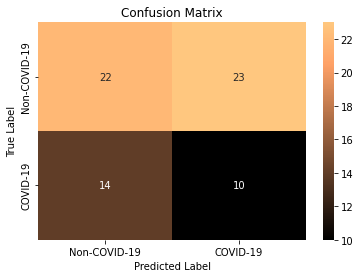

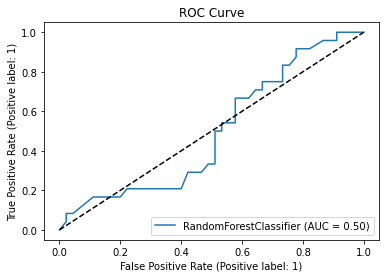

In [35]:
# Domain/Search Space
space = {'bootstrap': [True, False],
         'max_depth': [5, 7, 8, 10, None],
         'min_samples_leaf': [1, 2, 5],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [10, 20 , 50, 100, 200]}

# training
model = RandomForestClassifier()
call('RF', model, space)

# Gradient Boosting

Best training parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}
Training set score: 0.664
Test set score: 0.435
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       0.60      0.40      0.48        45
    COVID-19       0.31      0.50      0.38        24

    accuracy                           0.43        69
   macro avg       0.45      0.45      0.43        69
weighted avg       0.50      0.43      0.45        69

****************************************************************************************************


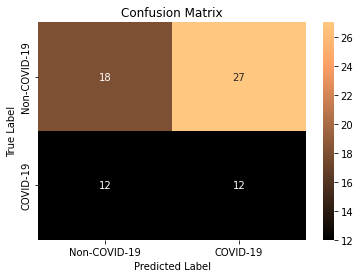

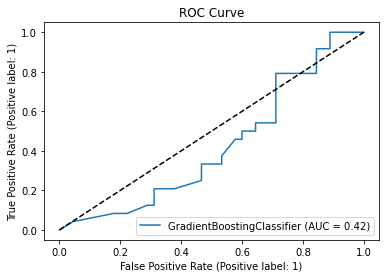

In [36]:
# Domain/Search Space
space = {'max_depth': [5, 7, 8, 10, None],
         'min_samples_leaf': [1, 2, 5],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [10, 20 , 50, 100, 200]}

# training
model = GradientBoostingClassifier()
call('GB', model, space)

# Logistic Regression

Best training parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Training set score: 0.585
Test set score: 0.536
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       0.71      0.49      0.58        45
    COVID-19       0.39      0.62      0.48        24

    accuracy                           0.54        69
   macro avg       0.55      0.56      0.53        69
weighted avg       0.60      0.54      0.55        69

****************************************************************************************************


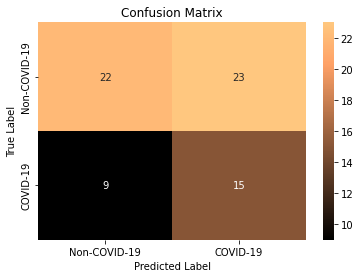

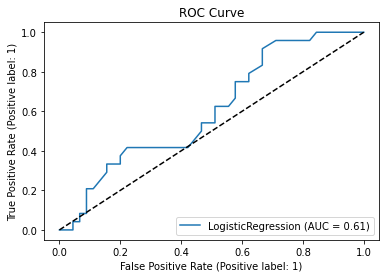

In [37]:
# Domain/Search Space
space = {'penalty' : ['l1', 'l2','elasticnet','none'], 
                 'C' : [0.01, 0.1, 1, 10, 100],
                 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# training
model = LogisticRegression()
call('LR', model, space)

# K-NN

Best training parameters: {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 19}
Training set score: 0.631
Test set score: 0.522
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       0.69      0.49      0.57        45
    COVID-19       0.38      0.58      0.46        24

    accuracy                           0.52        69
   macro avg       0.53      0.54      0.52        69
weighted avg       0.58      0.52      0.53        69

****************************************************************************************************


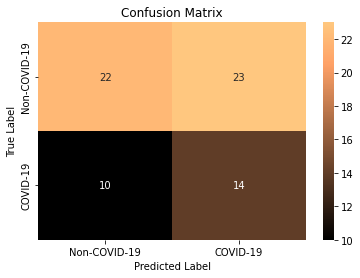

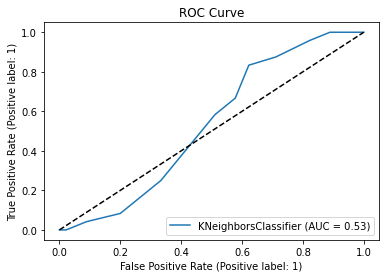

In [38]:
# Domain/Search Space
space = {'n_neighbors' : list(range(3,20,2)),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'metric' : ['euclidean','manhattan','chebyshev','minkowski']}

# training
model = KNeighborsClassifier()
call('KNN', model, space)

# SVM

Best training parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
Training set score: 0.533
Test set score: 0.435
****************************************************************************************************
****************************************************************************************************
              precision    recall  f1-score   support

Non-COVID-19       1.00      0.13      0.24        45
    COVID-19       0.38      1.00      0.55        24

    accuracy                           0.43        69
   macro avg       0.69      0.57      0.39        69
weighted avg       0.78      0.43      0.35        69

****************************************************************************************************


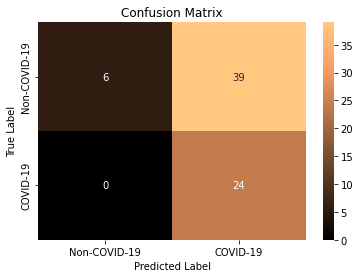

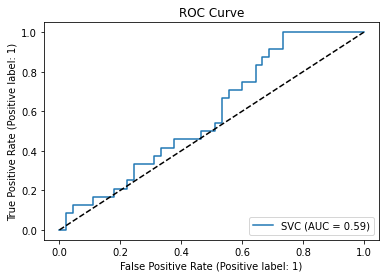

In [39]:
# Domain/Search Space
space = {'C': [0.01, 0.1, 1, 10, 100], 
 'gamma': [1, 0.1, 0.01, 0.001],
 'kernel': ['linear','rbf', 'poly', 'sigmoid']}

# training
model = SVC()
call('SVM', model, space)

In [40]:
models

{'NB': GaussianNB(var_smoothing=1.0),
 'RF': RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=10),
 'GB': GradientBoostingClassifier(max_depth=5, min_samples_leaf=5, n_estimators=10),
 'LR': LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
 'KNN': KNeighborsClassifier(metric='chebyshev', n_neighbors=19),
 'SVM': SVC(C=1, gamma=0.1, kernel='poly')}

In [41]:
params

{'NB': {'var_smoothing': 1.0},
 'RF': {'bootstrap': False,
  'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 10},
 'GB': {'max_depth': 5,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 10},
 'LR': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'},
 'KNN': {'algorithm': 'auto', 'metric': 'chebyshev', 'n_neighbors': 19},
 'SVM': {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}}

# Save models

In [42]:
path = 'models/PatientLevel/'

In [43]:
# save models
for i in models:
    filename = i+'_PatientLevel.sav'
    clf = models[i]
    pickle.dump(clf, open(path+filename, 'wb'))